In [1]:
import pandas as pd

import xgboost as xgb

import seaborn as sns

import optuna
import optuna_integration

from sklearn.metrics import roc_auc_score

from math import sqrt

from datetime import datetime

#### Load data

In [2]:
Y_train = pd.read_csv("../../data/ld50/train.csv")[["Class"]]
Y_test = pd.read_csv("../../data/ld50/test.csv")[["Class"]]

X_train = pd.read_csv("train_embeddings.csv")
X_test = pd.read_csv("test_embeddings.csv")

In [3]:
dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test, Y_test)

<Axes: >

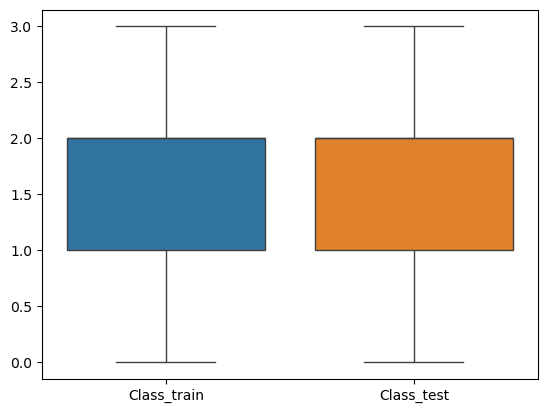

In [4]:
plot_df = Y_train.join(Y_test, lsuffix="_train", rsuffix="_test")
sns.boxplot(plot_df)

#### Train

In [5]:
best_model = None
best_eval_metric = float("inf")

def objective(trial):
    global best_model
    global best_eval_metric

    num_rounds = 5000
    param = {
        'verbosity': 0,
        'objective': 'multi:softprob',
        'num_class': Y_train["Class"].nunique(),
        'eval_metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 2, 6), 
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1),
        'subsample': 0.9,
        'colsample_bytree': 0.5,
    }

    evallist = [(dtest, 'test')]
    bst = xgb.train(param, dtrain, num_rounds, evals=evallist,
                    early_stopping_rounds=trial.suggest_int('early_stop', 10, 100), 
                    verbose_eval=num_rounds,
                    callbacks=[optuna_integration.XGBoostPruningCallback(trial, 'test-auc')])

    y = bst.predict(dtest)
    eval_metric = roc_auc_score(Y_test.to_numpy()[:, 0], y, multi_class='ovr')

    if eval_metric < best_eval_metric:
        best_eval_metric = eval_metric
        best_model = bst

    return eval_metric


study = optuna.create_study(direction='maximize', 
                            storage="sqlite:///XGB_Tox_Pred.sqlite3", 
                            study_name=f"Classification{datetime.now().isoformat()}")
study.optimize(objective, n_trials=100)

[I 2024-06-18 13:46:46,049] A new study created in RDB with name: Classification2024-06-18T13:46:45.807572


[0]	test-auc:0.62867
[1732]	test-auc:0.80311


[I 2024-06-18 13:48:42,665] Trial 0 finished with value: 0.8336820731818795 and parameters: {'max_depth': 3, 'learning_rate': 0.09878762436451703, 'early_stop': 82}. Best is trial 0 with value: 0.8336820731818795.


[0]	test-auc:0.63713
[400]	test-auc:0.80738


[I 2024-06-18 13:49:20,768] Trial 1 finished with value: 0.8364875792758423 and parameters: {'max_depth': 5, 'learning_rate': 0.08877340699971338, 'early_stop': 23}. Best is trial 1 with value: 0.8364875792758423.


[0]	test-auc:0.61035
[2884]	test-auc:0.78715


[I 2024-06-18 13:52:29,348] Trial 2 finished with value: 0.819365078674247 and parameters: {'max_depth': 2, 'learning_rate': 0.052161705824271834, 'early_stop': 95}. Best is trial 1 with value: 0.8364875792758423.


[0]	test-auc:0.64668
[309]	test-auc:0.80447


[I 2024-06-18 13:53:09,203] Trial 3 finished with value: 0.8344847502793558 and parameters: {'max_depth': 6, 'learning_rate': 0.08764267190714302, 'early_stop': 24}. Best is trial 1 with value: 0.8364875792758423.


[0]	test-auc:0.63389
[744]	test-auc:0.80587


[I 2024-06-18 13:54:02,141] Trial 4 finished with value: 0.8371911521754891 and parameters: {'max_depth': 4, 'learning_rate': 0.07076956576815961, 'early_stop': 56}. Best is trial 4 with value: 0.8371911521754891.


[0]	test-auc:0.63713
[900]	test-auc:0.81107


[I 2024-06-18 13:55:28,972] Trial 5 finished with value: 0.8406484449526012 and parameters: {'max_depth': 5, 'learning_rate': 0.04739649566195436, 'early_stop': 17}. Best is trial 5 with value: 0.8406484449526012.


[0]	test-auc:0.64661


[I 2024-06-18 13:55:34,381] Trial 6 pruned. Trial was pruned at iteration 34.
[I 2024-06-18 13:55:34,469] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.63385


[I 2024-06-18 13:55:34,643] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64666
[1289]	test-auc:0.81169


[I 2024-06-18 13:58:20,489] Trial 9 finished with value: 0.8417237530871088 and parameters: {'max_depth': 6, 'learning_rate': 0.027288848029956608, 'early_stop': 91}. Best is trial 9 with value: 0.8417237530871088.


[0]	test-auc:0.63707


[I 2024-06-18 13:58:20,719] Trial 10 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.63707


[I 2024-06-18 13:58:20,912] Trial 11 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64668
[372]	test-auc:0.80550


[I 2024-06-18 13:59:09,219] Trial 12 finished with value: 0.8353548985810212 and parameters: {'max_depth': 6, 'learning_rate': 0.03842388022465048, 'early_stop': 12}. Best is trial 9 with value: 0.8417237530871088.


[0]	test-auc:0.63716


[I 2024-06-18 13:59:09,527] Trial 13 pruned. Trial was pruned at iteration 1.


[0]	test-auc:0.64666


[I 2024-06-18 13:59:22,833] Trial 14 pruned. Trial was pruned at iteration 92.


[0]	test-auc:0.63713


[I 2024-06-18 13:59:22,980] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2024-06-18 13:59:23,098] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.62880


[I 2024-06-18 13:59:23,205] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64667
[360]	test-auc:0.80459


[I 2024-06-18 14:00:09,791] Trial 18 finished with value: 0.8346650039205924 and parameters: {'max_depth': 6, 'learning_rate': 0.04231567889317259, 'early_stop': 13}. Best is trial 9 with value: 0.8417237530871088.
[I 2024-06-18 14:00:09,908] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2024-06-18 14:00:10,064] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2024-06-18 14:00:10,177] Trial 21 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.62876


[I 2024-06-18 14:00:10,279] Trial 22 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.63387


[I 2024-06-18 14:00:10,397] Trial 23 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.63718


[I 2024-06-18 14:00:10,641] Trial 24 pruned. Trial was pruned at iteration 1.


[0]	test-auc:0.64667
[831]	test-auc:0.81087


[I 2024-06-18 14:01:53,301] Trial 25 finished with value: 0.8403538071435945 and parameters: {'max_depth': 6, 'learning_rate': 0.04566318073578268, 'early_stop': 76}. Best is trial 9 with value: 0.8417237530871088.


[0]	test-auc:0.64668
[992]	test-auc:0.81115


[I 2024-06-18 14:03:53,131] Trial 26 finished with value: 0.8414188687539751 and parameters: {'max_depth': 6, 'learning_rate': 0.04435626520068417, 'early_stop': 77}. Best is trial 9 with value: 0.8417237530871088.


[0]	test-auc:0.64667


[I 2024-06-18 14:03:53,596] Trial 27 pruned. Trial was pruned at iteration 1.
[I 2024-06-18 14:03:53,834] Trial 28 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.63706


[I 2024-06-18 14:03:54,005] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64673


[I 2024-06-18 14:03:54,360] Trial 30 pruned. Trial was pruned at iteration 1.


[0]	test-auc:0.64667


[I 2024-06-18 14:04:08,279] Trial 31 pruned. Trial was pruned at iteration 91.


[0]	test-auc:0.64667
[752]	test-auc:0.81210


[I 2024-06-18 14:05:45,287] Trial 32 finished with value: 0.8414351232632729 and parameters: {'max_depth': 6, 'learning_rate': 0.0456716018730499, 'early_stop': 71}. Best is trial 9 with value: 0.8417237530871088.
[I 2024-06-18 14:05:45,455] Trial 33 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64667


[I 2024-06-18 14:05:45,957] Trial 34 pruned. Trial was pruned at iteration 2.
[I 2024-06-18 14:05:46,184] Trial 35 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64668


[I 2024-06-18 14:05:58,872] Trial 36 pruned. Trial was pruned at iteration 85.
[I 2024-06-18 14:05:59,071] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2024-06-18 14:05:59,291] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2024-06-18 14:05:59,444] Trial 39 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.61039


[I 2024-06-18 14:05:59,536] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64667


[I 2024-06-18 14:05:59,874] Trial 41 pruned. Trial was pruned at iteration 1.


[0]	test-auc:0.64666


[I 2024-06-18 14:06:00,073] Trial 42 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64668


[I 2024-06-18 14:06:00,906] Trial 43 pruned. Trial was pruned at iteration 4.


[0]	test-auc:0.64663


[I 2024-06-18 14:06:01,141] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2024-06-18 14:06:01,340] Trial 45 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64670
[921]	test-auc:0.81243


[I 2024-06-18 14:07:41,240] Trial 46 finished with value: 0.8413054573019065 and parameters: {'max_depth': 6, 'learning_rate': 0.09315544468228305, 'early_stop': 88}. Best is trial 9 with value: 0.8417237530871088.


[0]	test-auc:0.64670
[1097]	test-auc:0.81174


[I 2024-06-18 14:09:38,189] Trial 47 finished with value: 0.840633852677566 and parameters: {'max_depth': 6, 'learning_rate': 0.08887510184053092, 'early_stop': 96}. Best is trial 9 with value: 0.8417237530871088.
[I 2024-06-18 14:09:38,442] Trial 48 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64663


[I 2024-06-18 14:09:38,709] Trial 49 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.63713


[I 2024-06-18 14:09:38,899] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64670
[920]	test-auc:0.81292


[I 2024-06-18 14:11:19,831] Trial 51 finished with value: 0.8422180469392971 and parameters: {'max_depth': 6, 'learning_rate': 0.09280042303299703, 'early_stop': 97}. Best is trial 51 with value: 0.8422180469392971.


[0]	test-auc:0.64671
[663]	test-auc:0.81081


[I 2024-06-18 14:12:33,988] Trial 52 finished with value: 0.8407054149847212 and parameters: {'max_depth': 6, 'learning_rate': 0.09585416945583831, 'early_stop': 91}. Best is trial 51 with value: 0.8422180469392971.


[0]	test-auc:0.64669
[614]	test-auc:0.81080


[I 2024-06-18 14:13:46,369] Trial 53 finished with value: 0.8403635132364187 and parameters: {'max_depth': 6, 'learning_rate': 0.0916829518374516, 'early_stop': 91}. Best is trial 51 with value: 0.8422180469392971.


[0]	test-auc:0.64671
[1004]	test-auc:0.81310


[I 2024-06-18 14:15:31,792] Trial 54 finished with value: 0.8415717827343584 and parameters: {'max_depth': 6, 'learning_rate': 0.0969028268883576, 'early_stop': 95}. Best is trial 51 with value: 0.8422180469392971.


[0]	test-auc:0.64667
[890]	test-auc:0.81183


[I 2024-06-18 14:17:17,460] Trial 55 finished with value: 0.8411748100057096 and parameters: {'max_depth': 6, 'learning_rate': 0.08644161307597002, 'early_stop': 96}. Best is trial 51 with value: 0.8422180469392971.
[I 2024-06-18 14:17:17,702] Trial 56 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64671
[486]	test-auc:0.80967


[I 2024-06-18 14:18:15,160] Trial 57 finished with value: 0.8398443543077682 and parameters: {'max_depth': 6, 'learning_rate': 0.09585691171778406, 'early_stop': 85}. Best is trial 51 with value: 0.8422180469392971.


[0]	test-auc:0.64668


[I 2024-06-18 14:18:56,145] Trial 58 pruned. Trial was pruned at iteration 342.


[0]	test-auc:0.62874


[I 2024-06-18 14:18:56,250] Trial 59 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64665


[I 2024-06-18 14:18:56,512] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64669


[I 2024-06-18 14:20:34,938] Trial 61 pruned. Trial was pruned at iteration 915.


[0]	test-auc:0.64671
[715]	test-auc:0.81329


[I 2024-06-18 14:22:01,587] Trial 62 finished with value: 0.8421259450144742 and parameters: {'max_depth': 6, 'learning_rate': 0.09611240708785616, 'early_stop': 97}. Best is trial 51 with value: 0.8422180469392971.


[0]	test-auc:0.64671


[I 2024-06-18 14:22:34,428] Trial 63 pruned. Trial was pruned at iteration 236.


[0]	test-auc:0.64672


[I 2024-06-18 14:22:34,792] Trial 64 pruned. Trial was pruned at iteration 1.


[0]	test-auc:0.64669
[459]	test-auc:0.81051


[I 2024-06-18 14:23:31,789] Trial 65 finished with value: 0.8400612734438033 and parameters: {'max_depth': 6, 'learning_rate': 0.09168281210634432, 'early_stop': 84}. Best is trial 51 with value: 0.8422180469392971.
[I 2024-06-18 14:23:32,009] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64670


[I 2024-06-18 14:23:32,427] Trial 67 pruned. Trial was pruned at iteration 1.
[I 2024-06-18 14:23:32,591] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2024-06-18 14:23:32,804] Trial 69 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64665


[I 2024-06-18 14:23:33,021] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64672
[360]	test-auc:0.80868


[I 2024-06-18 14:24:19,077] Trial 71 finished with value: 0.8372232667804963 and parameters: {'max_depth': 6, 'learning_rate': 0.0971531289166709, 'early_stop': 95}. Best is trial 51 with value: 0.8422180469392971.


[0]	test-auc:0.64669
[959]	test-auc:0.81188


[I 2024-06-18 14:26:04,852] Trial 72 finished with value: 0.8408869949977098 and parameters: {'max_depth': 6, 'learning_rate': 0.08936604661059352, 'early_stop': 97}. Best is trial 51 with value: 0.8422180469392971.


[0]	test-auc:0.64668


[I 2024-06-18 14:26:05,368] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64673


[I 2024-06-18 14:26:06,092] Trial 74 pruned. Trial was pruned at iteration 1.


[0]	test-auc:0.64668


[I 2024-06-18 14:26:06,494] Trial 75 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64669
[661]	test-auc:0.81131


[I 2024-06-18 14:27:19,867] Trial 76 finished with value: 0.8397584738662283 and parameters: {'max_depth': 6, 'learning_rate': 0.09090997812156656, 'early_stop': 98}. Best is trial 51 with value: 0.8422180469392971.
[I 2024-06-18 14:27:20,160] Trial 77 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64670


[I 2024-06-18 14:27:21,169] Trial 78 pruned. Trial was pruned at iteration 1.
[I 2024-06-18 14:27:21,353] Trial 79 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.63706


[I 2024-06-18 14:27:21,585] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64669
[702]	test-auc:0.81229


[I 2024-06-18 14:42:40,127] Trial 81 finished with value: 0.841215307539453 and parameters: {'max_depth': 6, 'learning_rate': 0.0892436123150427, 'early_stop': 97}. Best is trial 51 with value: 0.8422180469392971.


[0]	test-auc:0.64671


[I 2024-06-18 14:42:40,682] Trial 82 pruned. Trial was pruned at iteration 2.
[I 2024-06-18 14:42:40,889] Trial 83 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64667


[I 2024-06-18 14:42:41,106] Trial 84 pruned. Trial was pruned at iteration 0.
[I 2024-06-18 14:42:41,321] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2024-06-18 14:42:41,525] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.61028


[I 2024-06-18 14:42:41,626] Trial 87 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64670


[I 2024-06-18 14:42:41,964] Trial 88 pruned. Trial was pruned at iteration 1.
[I 2024-06-18 14:42:42,197] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2024-06-18 14:42:42,447] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64670


[I 2024-06-18 14:42:44,879] Trial 91 pruned. Trial was pruned at iteration 15.


[0]	test-auc:0.64672


[I 2024-06-18 14:42:45,413] Trial 92 pruned. Trial was pruned at iteration 2.


[0]	test-auc:0.64670


[I 2024-06-18 14:42:46,248] Trial 93 pruned. Trial was pruned at iteration 4.


[0]	test-auc:0.64665


[I 2024-06-18 14:42:46,468] Trial 94 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64670


[I 2024-06-18 14:42:46,874] Trial 95 pruned. Trial was pruned at iteration 1.


[0]	test-auc:0.64669


[I 2024-06-18 14:43:01,353] Trial 96 pruned. Trial was pruned at iteration 104.


[0]	test-auc:0.64666


[I 2024-06-18 14:43:01,592] Trial 97 pruned. Trial was pruned at iteration 0.


[0]	test-auc:0.64668


[I 2024-06-18 14:43:01,834] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2024-06-18 14:43:02,066] Trial 99 pruned. Trial was pruned at iteration 0.


In [8]:
bst = best_model

NameError: name 'y' is not defined

In [9]:
from datetime import datetime
bst.save_model(f"xgboost_classfifcation_model_{datetime.now().isoformat()}.json")